<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/BERT_esm1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install and load models

In [1]:
# for other models see: https://github.com/facebookresearch/esm#main-models-you-should-use-
# this step will take ~7mins (~4 mins to download, ~2m to load)
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /root/.cache/torch/hub/facebookresearch_esm_main


In [2]:
# put model on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()
model.args.token_dropout = False

# alphabet size
esm_alphabet_len = len(alphabet.all_toks)
esm_alphabet = "".join(alphabet.all_toks[4:24])+"-"

In [3]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/algosb_2021/main/utils.py
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from utils import *

# analyze MSA

In [4]:
# RL29_ECOLI (essential ribosomal protein from ECOLI)
!wget -qnc https://files.ipd.uw.edu/krypton/RL29.uni.1e-10.i8.i90c75.a3m
headers, seqs = parse_fasta("RL29.uni.1e-10.i8.i90c75.a3m", a3m = True)
msa = mk_msa(seqs, alphabet=esm_alphabet)
seq = seqs[0]
print(msa.shape)
print(seq)

(11367, 63, 21)
MKAKELREKSVEELNTELLNLLREQFNLRMQAASGQLQQSHLLKQVRRDVARVKTLLNEKAGA


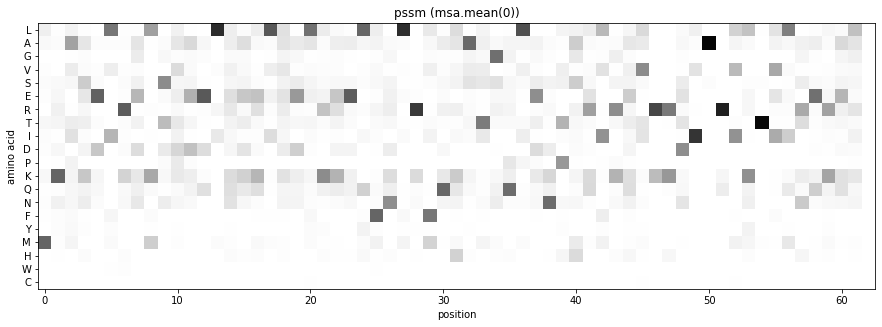

In [5]:
plt.figure(figsize=(15,5))
plt.title("pssm (msa.mean(0))")
plt.imshow(msa.mean(0)[...,:20].T, vmin=0, vmax=1, cmap="binary")
plt.yticks(range(20),esm_alphabet[:20])
plt.xlabel("position"); plt.ylabel("amino acid")
plt.show()

#analyze BERT-ESM1b

In [6]:
def get_logits(seq):
  x,ln = alphabet.get_batch_converter()([("seq",seq)])[-1],len(seq)
  with torch.no_grad():
    f = lambda x: model(x)["logits"][0,1:(ln+1),4:24].cpu().numpy()
    x = x.to(device)
    logits = f(x)
    return logits

def get_masked_logits(seq, p=None, get_pll=False):
  x,ln = alphabet.get_batch_converter()([(None,seq)])[-1],len(seq)
  if p is None: p = ln
  with torch.no_grad():
    def f(x):
      fx = model(x)["logits"][:,1:(ln+1),4:24]
      return fx

    logits = np.zeros((ln,20))
    for n in range(0,ln,p):
      m = min(n+p,ln)
      x_h = torch.tile(torch.clone(x),[m-n,1])
      for i in range(m-n):
        x_h[i,n+i+1] = alphabet.mask_idx
      fx_h = f(x_h.to(device))
      for i in range(m-n):
        logits[n+i] = fx_h[i,n+i].cpu().numpy()
  if get_pll:
    logits = np.log(softmax(logits,-1))
    x = x.cpu().numpy()[0]
    x = x[1:(ln+1)] - 4
    return sum([logits[n,i] for n,i in enumerate(x)])
  else:
    return logits

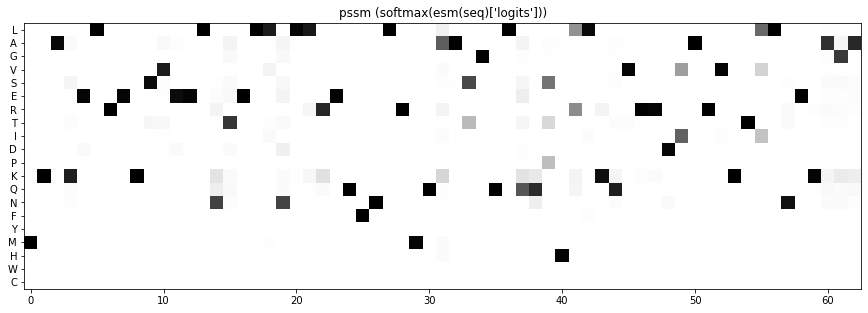

In [7]:
# get PSSM version 1
plt.figure(figsize=(15,5))
plt.title("pssm (softmax(esm(seq)['logits']))")
plt.imshow(softmax(get_logits(seq),-1).T, vmin=0, vmax=1, cmap="binary")
plt.yticks(range(20),esm_alphabet[:20])
plt.show()

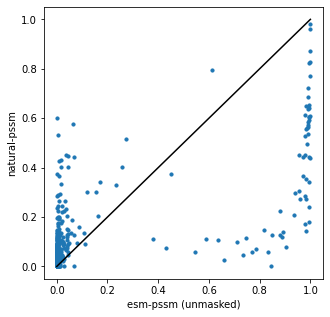

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(softmax(get_logits(seq),-1),
            msa.mean(0)[...,:20],s=10)
plt.xlabel("esm-pssm (unmasked)")
plt.ylabel("natural-pssm")
plt.plot([0,1],[0,1],color="black")
plt.show()

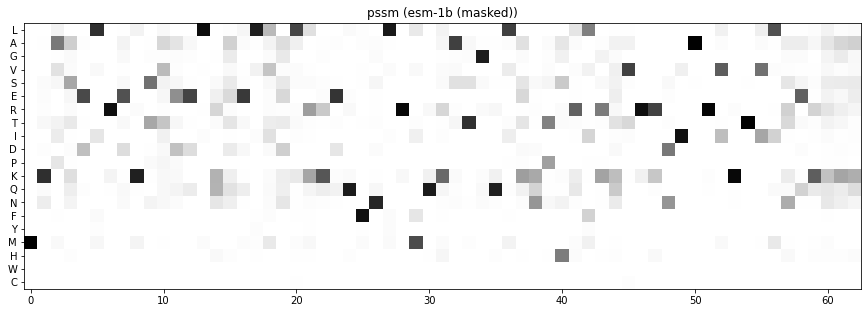

In [9]:
# get PSSM version 2
# mask one position at a time
plt.figure(figsize=(15,5))
plt.title("pssm (esm-1b (masked))")
plt.imshow(softmax(get_masked_logits(seq),-1).T, cmap="binary", vmin=0, vmax=1)
plt.yticks(range(20),esm_alphabet[:20])
plt.show()

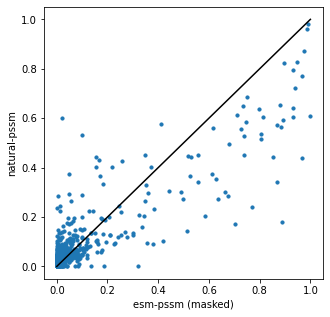

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(softmax(get_masked_logits(seq),-1),
            msa.mean(0)[...,:20],s=10)
plt.xlabel("esm-pssm (masked)")
plt.ylabel("natural-pssm")
plt.plot([0,1],[0,1],color="black")
plt.show()

In [11]:
# pseudo-likelihood (higher better)
get_masked_logits(seq, get_pll=True)

-57.53443746812438

In [12]:
def get_categorical_jacobian(seq):
  # ∂in/∂out
  x,ln = alphabet.get_batch_converter()([("seq",seq)])[-1],len(seq)
  with torch.no_grad():
    f = lambda x: model(x)["logits"][...,1:(ln+1),4:24].cpu().numpy()
    fx = f(x.to(device))[0]
    x = torch.tile(x,[20,1]).to(device)
    fx_h = np.zeros((ln,20,ln,20))
    for n in range(ln): # for each position
      x_h = torch.clone(x)
      x_h[:,n+1] = torch.arange(4,24) # mutate to all 20 aa
      fx_h[n] = f(x_h)
    return fx-fx_h

In [13]:
# jacobian of the model
jac = get_categorical_jacobian(seq)
# center & symmetrize
for i in range(4): jac -= jac.mean(i,keepdims=True)
jac = (jac + jac.transpose(2,3,0,1))/2

In [18]:
# inverse_covariance of natural msa
tmp = inv_cov_jax(msa)
L = len(seq)
ic = tmp["ic"].reshape(L,21,L,21)[:,:20,:,:20]

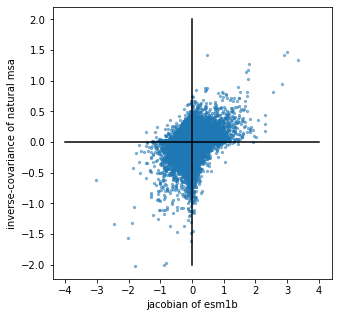

In [19]:
idx = np.triu_indices(L,1)
plt.figure(figsize=(5,5))
plt.scatter(jac[idx[0],:,idx[1],:],
            ic[idx[0],:,idx[1],:],s=5,alpha=0.5)
plt.xlabel("jacobian of esm1b")
plt.ylabel("inverse-covariance of natural msa")
plt.plot([0,0],[-2,2],color="black")
plt.plot([-4,4],[0,0],color="black")

extract contacts

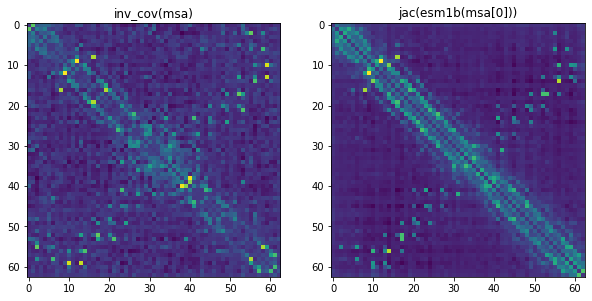

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("inv_cov(msa)"); plt.imshow(tmp["apc"])
plt.subplot(1,2,2); plt.title("jac(esm1b(msa[0]))"); plt.imshow(get_contacts(jac))
plt.show()

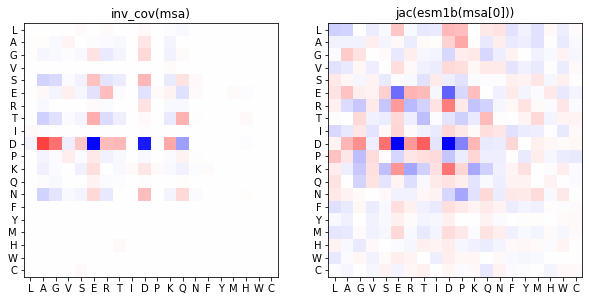

In [21]:
i = 9
j = 12

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
plt.title("inv_cov(msa)");
plt.imshow(ic[i,:,j,:],vmin=-1.5,vmax=1.5,cmap="bwr_r")
plt.xticks(range(20),esm_alphabet[:20])
plt.yticks(range(20),esm_alphabet[:20])

plt.subplot(1,2,2);
plt.title("jac(esm1b(msa[0]))");
plt.imshow(jac[i,:,j,:],vmin=-3,vmax=3,cmap="bwr_r")
plt.xticks(range(20),esm_alphabet[:20])
plt.yticks(range(20),esm_alphabet[:20])
plt.show()